<a href="https://colab.research.google.com/github/codeavenger456/BrainTumourDetection/blob/main/tumour_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!ls "/content/drive/My Drive/MAIS"

dataset1  dataset2  dataset3  modelCNN.h5


In [ ]:
import os
path = './drive/My Drive/MAIS/'
entries = os.listdir('./drive/My Drive/MAIS/')
images = []
for i in entries:
  if "dataset" in i:
    for j in os.listdir(path + i):
      for k in os.listdir(path + i + "/" + j):
        images.append(path + i + "/" + j + "/" + k)

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
import random
from tensorflow.keras import models, layers, optimizers
import matplotlib.pyplot as plt
import cv2

In [ ]:
nrows = 400  # height of image
ncolumns = 300  # width of image
channels = 1  # grayscale
proportion = 0.8  # 80% of the dataset is training data

In [ ]:
def generate(original):
  gen = list()
  for i in range(-1, 2):
    gen.append(cv2.flip(original, i))
  #gen.append(cv2.rotate(original, cv2.ROTATE_90_CLOCKWISE))
  gen.append(cv2.rotate(original, cv2.ROTATE_180))
  #gen.append(cv2.rotate(original, cv2.ROTATE_90_COUNTERCLOCKWISE))
  return gen

In [ ]:
def read_and_resize_image(list_of_images, train):
    # convert list of path to pair of array of grayscale and array of reponses
    X = list()
    y = list()
    for image in list_of_images:
        im = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
        height = im.shape[0]
        if height > nrows:
            # if original image height is bigger than we make it smaller
            resize = cv2.resize(im, (ncolumns, nrows), interpolation=cv2.INTER_CUBIC) 
        else:
            # else we make it bigger
            resize = cv2.resize(im, (ncolumns, nrows), interpolation=cv2.INTER_AREA)
        X.append(resize)
        if 'yes' in image:
            y.append(1)
        else:
          y.append(0)
          if train:
            augmented = generate(resize)
            for i in range(len(augmented)):
              X.append(augmented[i])
              y.append(0)
    return X, y

In [ ]:
random.shuffle(images)
images_train = images[:int(len(images) * proportion)]
images_test = images[int(len(images) * proportion):]

In [ ]:
train_X, train_y = read_and_resize_image(images_train, True)
X_train, X_val, y_train, y_val = train_test_split(train_X, train_y, test_size=0.20, random_state=2)# separate 20% of training data to validation set

X_train = np.expand_dims(X_train, axis=-1)
y_train = np.asarray(y_train)
X_val = np.expand_dims(X_val, axis=-1)
y_val = np.asarray(y_val)
np.reshape(X_train, (len(X_train), nrows, ncolumns, 1))

test_X, test_y = read_and_resize_image(images_test, False)
test_X = np.array(test_X).astype(np.float32)
test_X = np.expand_dims(test_X, axis=-1)

In [ ]:
input_shape = X_train.shape[1:]
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()
#https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html refer to this

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 398, 298, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 199, 149, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 197, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 98, 73, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 48, 35, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 46, 33, 128)       1

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(),
              metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=4,
                    validation_data=(X_val, y_val))

Epoch 1/4
38/38 [==============================] - 283s 7s/step - loss: 15.6616 - accuracy: 0.5970 - val_loss: 0.5593 - val_accuracy: 0.7000
Epoch 2/4
38/38 [==============================] - 286s 8s/step - loss: 0.5459 - accuracy: 0.7258 - val_loss: 0.5112 - val_accuracy: 0.7400
Epoch 3/4
38/38 [==============================] - 279s 7s/step - loss: 0.4560 - accuracy: 0.7860 - val_loss: 0.3933 - val_accuracy: 0.7933
Epoch 4/4
38/38 [==============================] - 281s 7s/step - loss: 0.4856 - accuracy: 0.7508 - val_loss: 0.5225 - val_accuracy: 0.6800


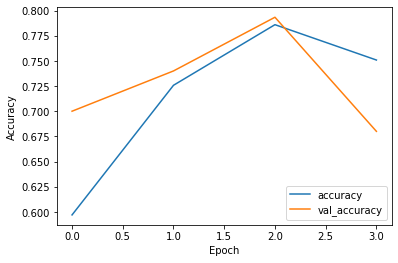

In [ ]:
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
y_predict = model.predict_classes(test_X)
y_predict = y_predict.T[0].tolist()

In [ ]:
true_positive = 0
false_positive = 0
true_negative = 0
false_negative = 0
for i, j in zip(y_predict, test_y):
  if i and j:
    true_positive += 1
  elif i and not j:
    false_positive += 1
  elif not i and j:
    false_negative += 1
  else:
    true_negative += 1
true_positive /= len(y_predict)
false_positive /= len(y_predict)
false_negative /= len(y_predict)
true_negative /= len(y_predict)
print(true_positive, false_negative, false_positive, true_negative)

0.8348214285714286 0.0 0.16071428571428573 0.004464285714285714


In [ ]:
model.save_weights("/content/drive/My Drive/MAIS/modelCNN.h5")

In [ ]:
import tensorflow as tf
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(),
              metrics=[tf.keras.metrics.FalsePositives()])
history = model.fit(X_train, y_train, epochs=50,
                    validation_data=(X_val, y_val))

Epoch 1/50
37/37 [==============================] - 271s 7s/step - loss: 27.4527 - false_positives: 204.0000 - val_loss: 0.5062 - val_false_positives: 11.0000
Epoch 2/50
37/37 [==============================] - 270s 7s/step - loss: 0.5027 - false_positives: 123.0000 - val_loss: 0.4765 - val_false_positives: 15.0000
Epoch 3/50
37/37 [==============================] - 269s 7s/step - loss: 0.4547 - false_positives: 119.0000 - val_loss: 0.4504 - val_false_positives: 12.0000
Epoch 4/50
37/37 [==============================] - 269s 7s/step - loss: 0.4337 - false_positives: 109.0000 - val_loss: 0.4394 - val_false_positives: 38.0000
Epoch 5/50
37/37 [==============================] - 269s 7s/step - loss: 0.4128 - false_positives: 103.0000 - val_loss: 0.3903 - val_false_positives: 23.0000
Epoch 6/50
37/37 [==============================] - 269s 7s/step - loss: 0.3580 - false_positives: 112.0000 - val_loss: 0.4459 - val_false_positives: 5.0000
Epoch 7/50
37/37 [==============================] - 

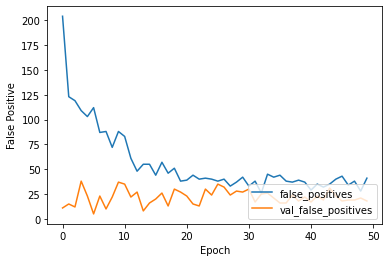

In [ ]:
plt.plot(history.history["false_positives"], label="false_positives")
plt.plot(history.history["val_false_positives"], label="val_false_positives")
plt.xlabel('Epoch')
plt.ylabel('False Positive')
plt.legend(loc='lower right')
plt.show()

In [ ]:
y_predict = model.predict_classes(test_X)
y_predict = y_predict.T[0].tolist()

In [ ]:
true_positive = 0
false_positive = 0
true_negative = 0
false_negative = 0
for i, j in zip(y_predict, test_y):
  if i and j:
    true_positive += 1
  elif i and not j:
    false_positive += 1
  elif not i and j:
    false_negative += 1
  else:
    true_negative += 1
true_positive /= len(y_predict)
false_positive /= len(y_predict)
false_negative /= len(y_predict)
true_negative /= len(y_predict)
print(true_positive, false_negative, false_positive, true_negative)

0.6160714285714286 0.17857142857142858 0.13392857142857142 0.07142857142857142
